In [2]:
import numpy as np
import networkx as nx
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from math import factorial as facto

In [3]:
# Définition des fonctions

def theta_model(theta:np.ndarray, beta:np.ndarray):
    return 1-np.cos(theta)+np.multiply(1+np.cos(theta), beta)

def spike_rep(theta:np.ndarray, n = 1):
   return (1-np.cos(theta))**n

def beta_Vconst(beta:float, beta_switch:bool, beta_low:float = -0.01, beta_high:float = 0.01):
    if beta >= 0.2:
       beta_switch = False
    elif beta <= -0.3:
       beta_switch = True
    if beta_switch:
        return beta_switch, beta_high
    else:
        return beta_switch, beta_low

def beta_const(beta:float, beta_switch:bool):
   return False, 0

def dynamique_1_neurone(time_step:int, time_stop:int, theta_0:float, beta_0:float, theta_model, beta_model, *kwarg):
  theta = np.array([theta_0])
  beta = np.array([beta_0])
  beta_switch = True
  for _ in range(int(time_stop/time_step)):
    Vtheta = theta_model(theta[-1], beta[-1])
    beta_switch, Vbeta = beta_model(beta[-1], beta_switch, *kwarg)
    theta = np.concatenate((theta, theta[-1:]+Vtheta*time_step))
    beta = np.concatenate((beta, beta[-1:]+Vbeta*time_step))
  return theta, beta

def beta2neurones(theta:np.ndarray, n:int = 2, seuil:float=0, kapa:float = 1): # point critique n:int = 1, seuil:float=-0.184151
   a_n = 2**n*(facto(n))**2/facto(2*n)
   # a_n = 1/2**(n+1)
   beta = spike_rep(theta, n)*a_n*kapa
   beta[[0, 1], :] = beta[[1, 0], :]
   return seuil + beta

def betaNneurones(theta_list:np.ndarray, A:np.ndarray, n:int = 2, seuil:float=0, kapa:float = 1):
   N = len(theta_list)
   a_n = 2**n*(facto(n))**2/facto(2*n)
   beta = np.zeros(np.shape(theta_list))
   for i in range(N):
      beta[i, 0] = np.sum(spike_rep(np.multiply(A[i], theta_list.T[0]), n))
   return seuil + a_n*kapa*beta/N

def dynamique_N_neurones(time_step:int, time_stop:int, theta_0:np.ndarray, theta_model, beta_model, *kwarg):
  theta = theta_0
  beta = beta_model(theta[:, -1:], *kwarg)
  for _ in range(int(time_stop/time_step)):
   Vtheta = theta_model(theta[:, -1:], beta[:, -1:])
   beta = np.concatenate((beta, beta_model(theta[:, -1:], *kwarg)), axis=1)
   theta = np.concatenate((theta, theta[:, -1:]+Vtheta*time_step), axis=1)
  return theta, beta

def indice_syncronisation(theta):
   return np.sqrt(np.sum(np.cos(theta), axis = 0)**2 + np.sum(np.sin(theta), axis = 0)**2)/len(theta)

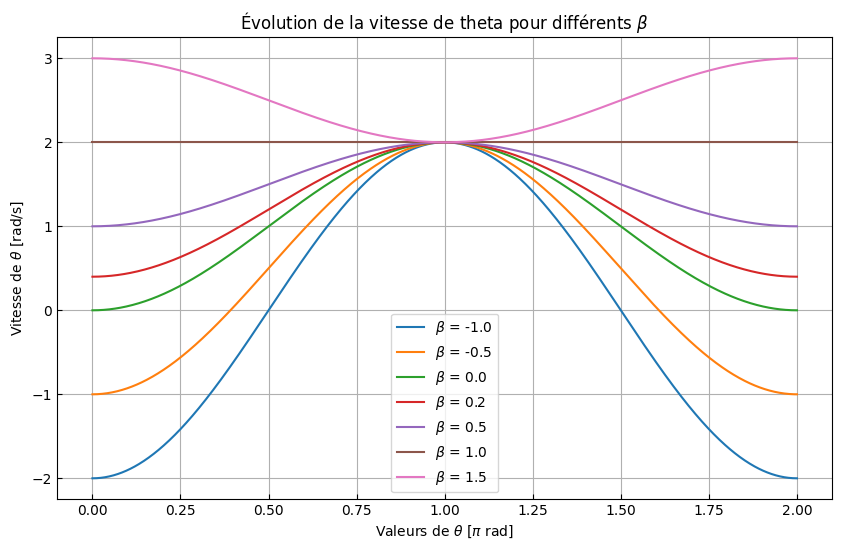

In [616]:
# Variation de la vitesse de theta selon theta pour plusieurs beta.
theta_list = np.linspace(0, 2*np.pi, 1000)
beta_list = np.array([-1, -0.5, 0, 0.2, 0.5, 1, 1.5])

plt.figure(figsize=(10, 6))

for beta in beta_list:
  plt.plot(theta_list/np.pi, theta_model(theta_list, beta), label=fr'$\beta$ = {beta}')#+f' {beta}'
plt.xlabel(r"Valeurs de $\theta$ [$\pi$ rad]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Évolution de la vitesse de theta pour différents $\beta$")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

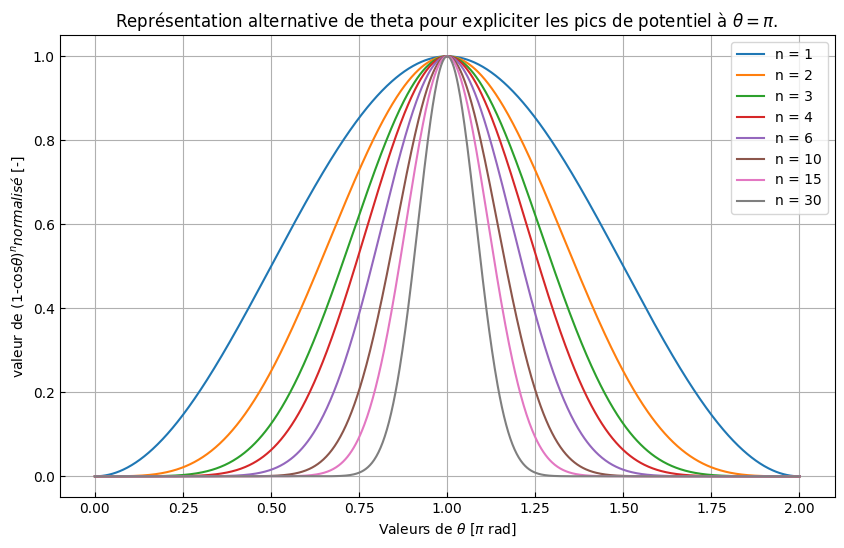

In [617]:
# Dynamique 1-cos(theta) et déffinition du pic
theta_list = np.linspace(0, 2*np.pi, 1000)
beta_list = np.array([-2, -1, -0.5, 0, 0.01, 0.1, 0.5, 1, 2])
spike_list = np.array([1, 2, 3, 4, 6, 10, 15, 30])

plt.figure(figsize=(10, 6))
for i in spike_list:
  ydata = spike_rep(theta_list, i)
  plt.plot(theta_list/np.pi, ydata/2**i, label=f'n = {i}')
plt.xlabel(r"Valeurs de $\theta$ [$\pi$ rad]")
plt.ylabel(r"valeur de (1-cos$\theta )^n normalisé$ [-]")
plt.title(r"Représentation alternative de theta pour expliciter les pics de potentiel à $\theta=\pi$.")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

theta = [0.00000000e+00 2.00000000e-03 4.00001800e-03 ... 6.29227294e+00
 6.29427331e+00 6.29627387e+00]
(1-cos($\theta$)$)^10$ = [0.00000000e+00 9.99996667e-61 1.04865639e-54 ... 1.40729927e-47
 7.52357248e-46 2.07574739e-44]


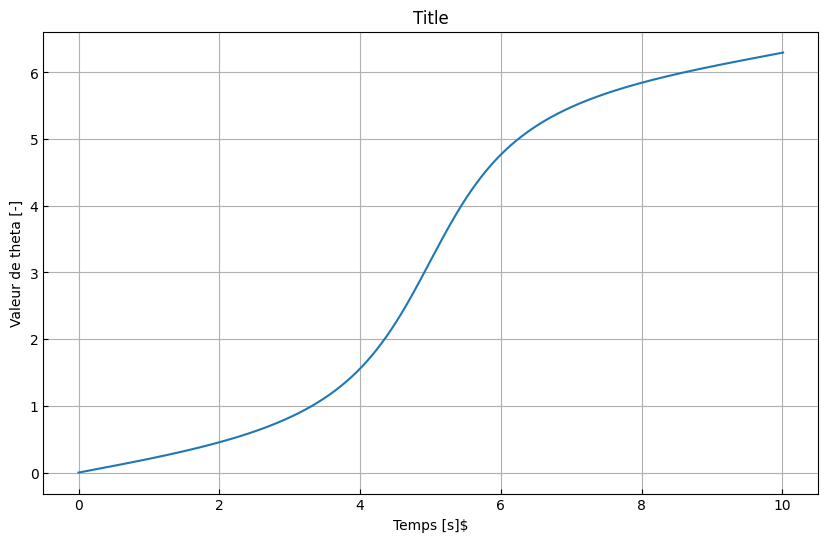

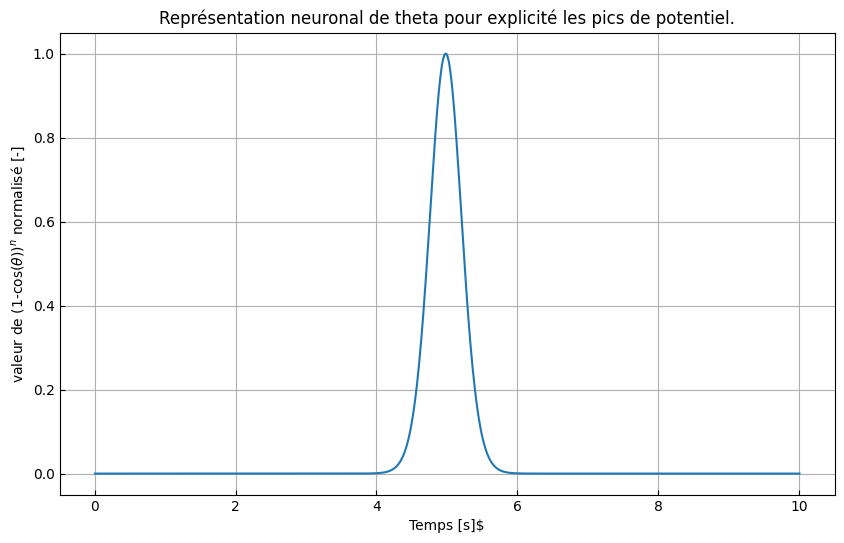

In [618]:
# Dynamique one spike  ---->  theta0 = 0      beta0 = 0.1    T = 10s
theta_0 = 0
beta_0 = 0.1

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
print(f'theta = {theta}')
print(fr'(1-cos($\theta$)$)^10$ = {(1-np.cos(theta))**10/2**10}')

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"Valeur de theta [-]")
plt.title("Title")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, (1-np.cos(theta))**10/2**10)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"valeur de (1-cos$(\theta ))^n$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

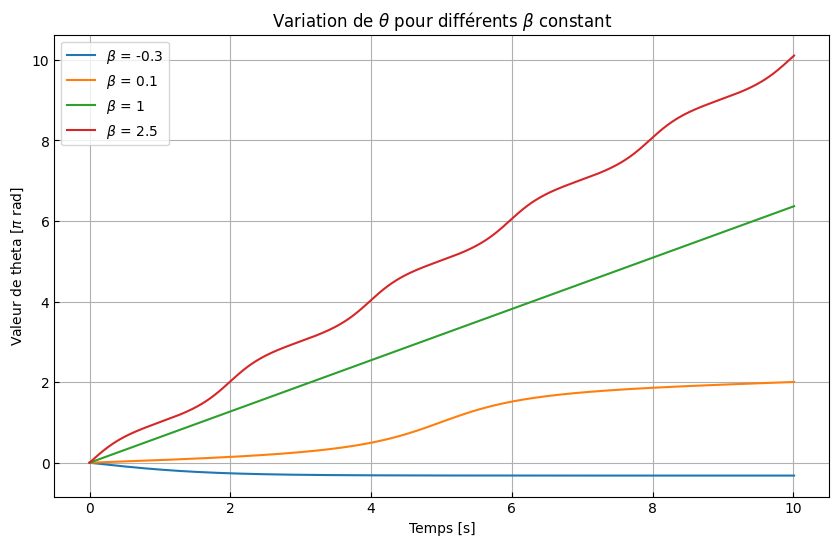

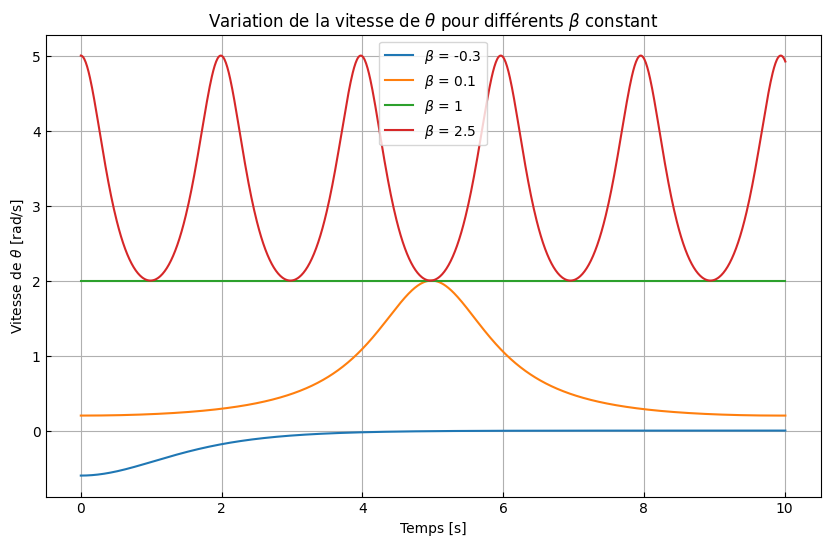

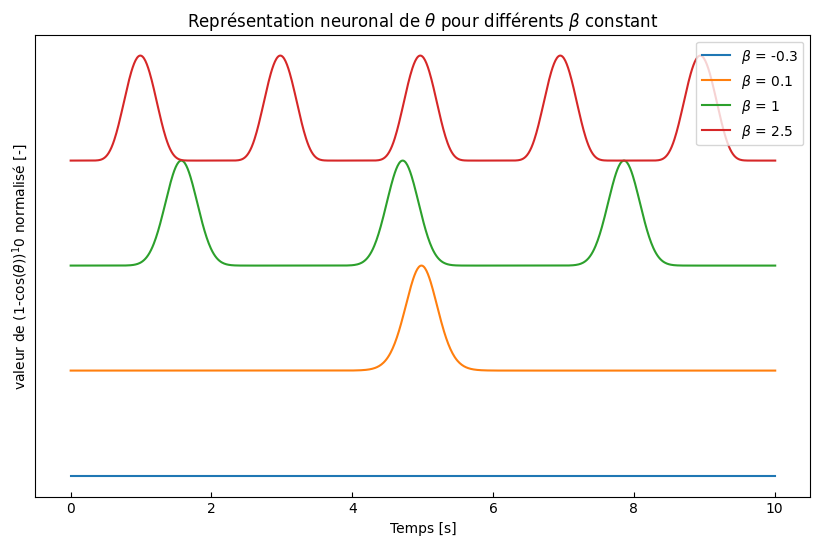

In [619]:
# Dynamique beta0 constant positif -----> effet sur theta  T = 10s
theta_0 = 0
beta_0_list = [-0.3, 0.1, 1, 2.5]

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta/np.pi, label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de theta [$\pi$ rad]")
plt.title(r"Variation de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta_model(theta, beta_0), label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for i, beta_0 in enumerate(beta_0_list):
    theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, i+(1-np.cos(theta))**10/2**10, label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^10$ normalisé [-]")
plt.title(r"Représentation neuronal de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.yticks(ticks=[])
plt.show()

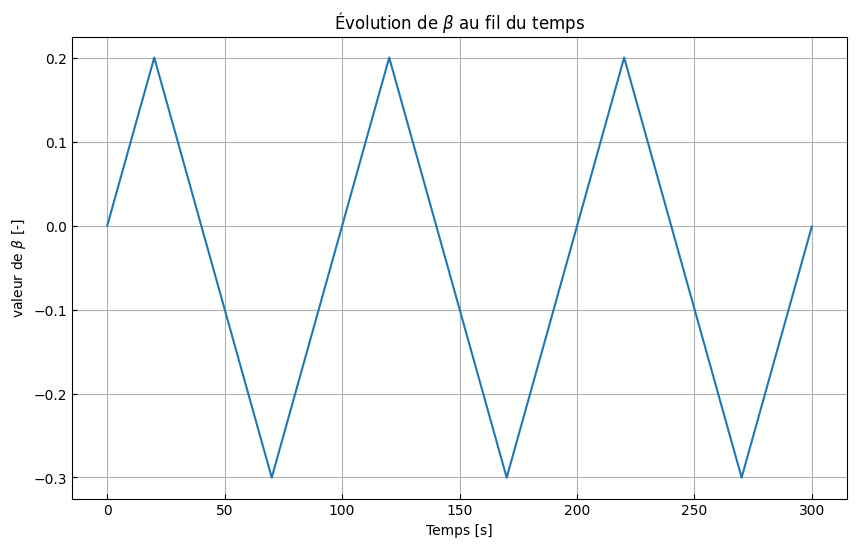

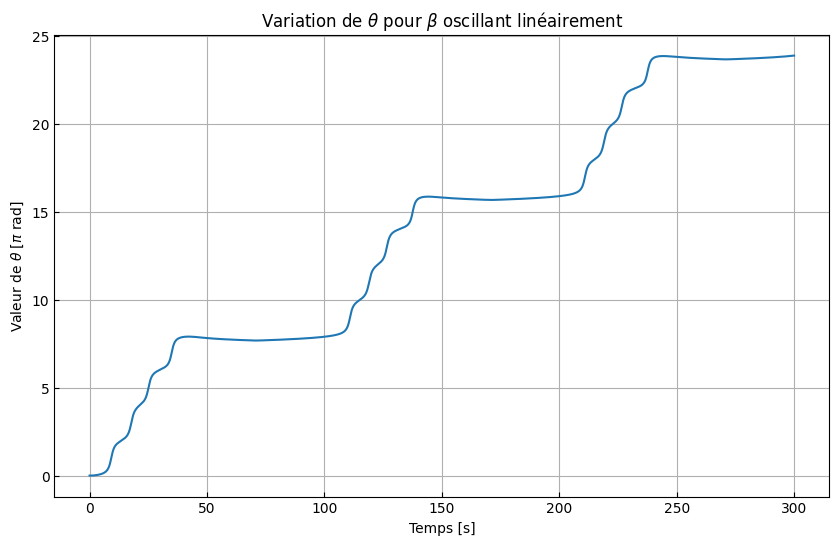

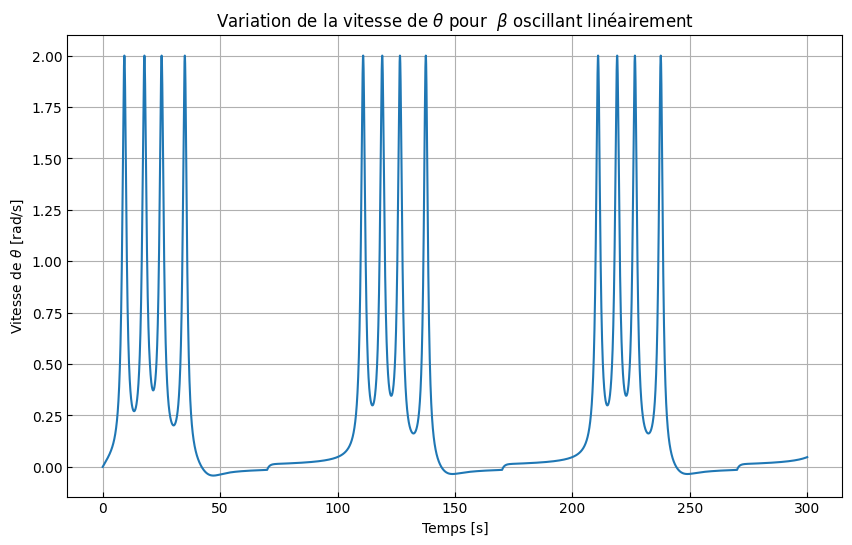

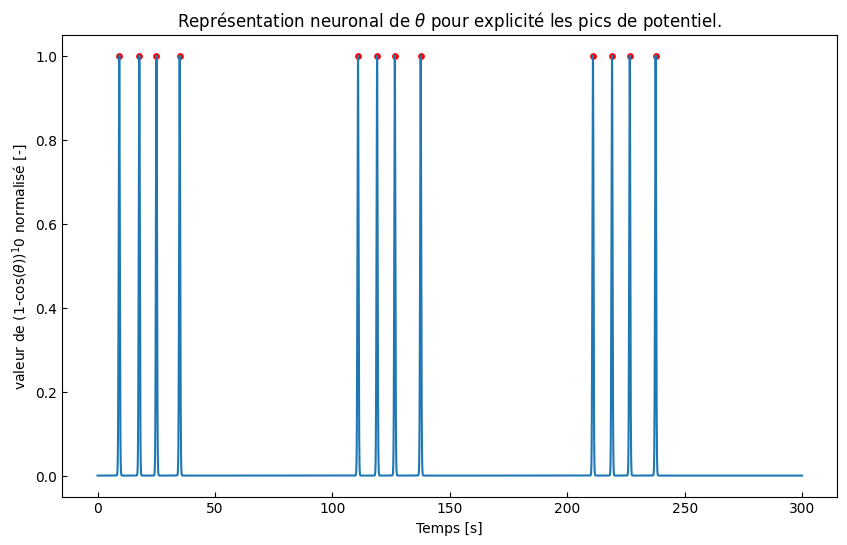

In [74]:
# Dynamique beta oscillant entre 0.2 et -0.3 a vitesse constante.
theta_0 = 0
beta_0  = 0 # Interessant de voir l'effet sur la vitesse de theta quand beta0 = 1.5
time_start = 0
time_step = 0.01
time_stop = 300
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_1_neurone(time_step, time_stop, theta_0, beta_0, theta_model, beta_Vconst, -0.01,  0.01)

plt.figure(figsize=(10, 6))
plt.plot(time_list, beta)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de $\beta$ [-]")
plt.title(r"Évolution de $\beta$ au fil du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta/np.pi)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de $\theta$ [$\pi$ rad]")
plt.title(r"Variation de $\theta$ pour $\beta$ oscillant linéairement")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta_model(theta, beta))
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$ pour  $\beta$ oscillant linéairement")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, spike_rep(theta, 10)/2**10)
peaks, properties = find_peaks(spike_rep(theta, 30)/2**30, 0.5)
plt.scatter(time_list[peaks], properties['peak_heights'], c='red', s=15)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^10$ normalisé [-]")
plt.title(r"Représentation neuronal de $\theta$ pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.show()




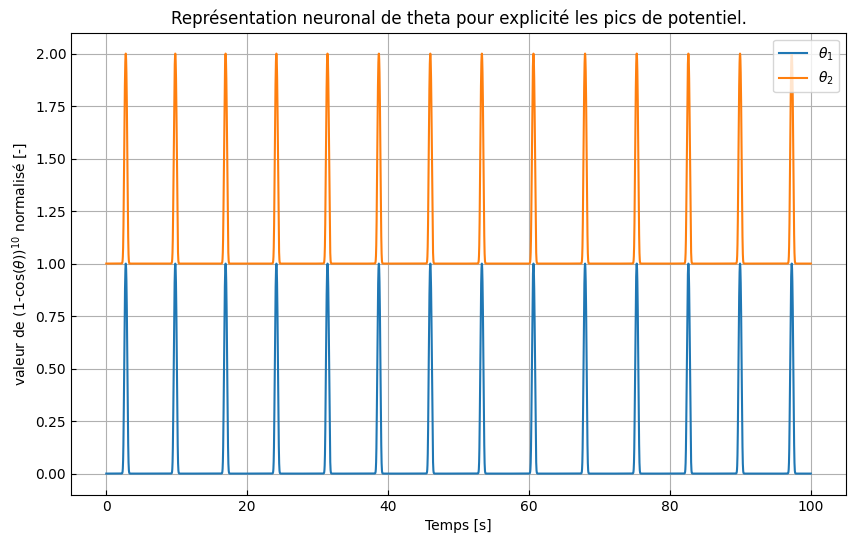

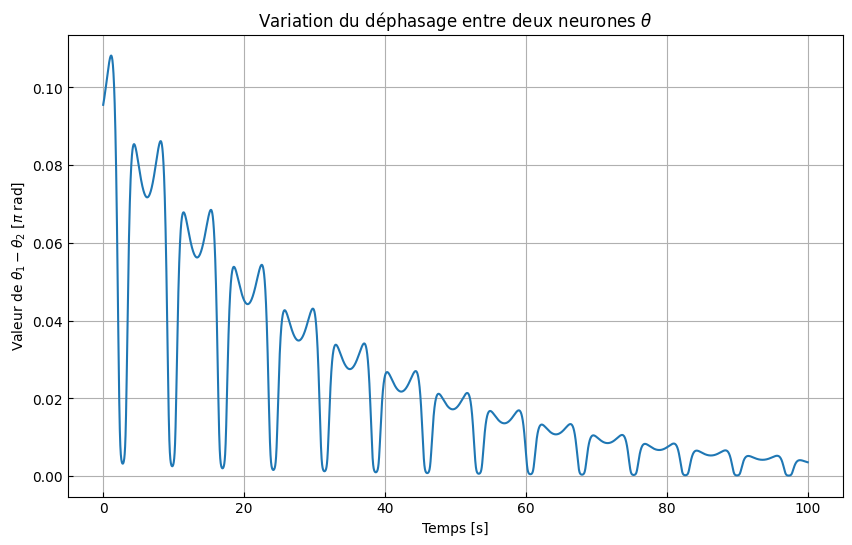

In [676]:
# Dynamique 2 neurones theta.
theta_0 = np.array([[0], [0.3]])
time_start = 0
time_step = 0.01
time_stop = 100
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, beta2neurones, 2, 0.1, 3)

# plt.figure(figsize=(10, 6))
# plt.plot(time_list, beta[0], label = r'$\theta_1$')
# plt.plot(time_list, beta[1], label = r'$\theta_2$')
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"valeur de $\beta$ [-]")
# plt.title(r"Évolution de $\beta$ au fils du temps")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.legend()
# plt.show()


plt.figure(figsize=(10, 6))
plt.plot(time_list, spike_rep(theta[0], 10)/2**10, label = r'$\theta_1$')
plt.plot(time_list, 1+spike_rep(theta[1], 10)/2**10, label = r'$\theta_2$')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^{10}$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, (theta[1]-theta[0])/np.pi)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de $\theta_1-\theta_2$ [$\pi$ rad]")
plt.title(r"Variation du déphasage entre deux neurones $\theta$")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(time_list, theta_model(theta[0], beta[0]))
# plt.plot(time_list, theta_model(theta[1], beta[1]))
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
# plt.title(r"Variation de la vitesse de $\theta$")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.show()

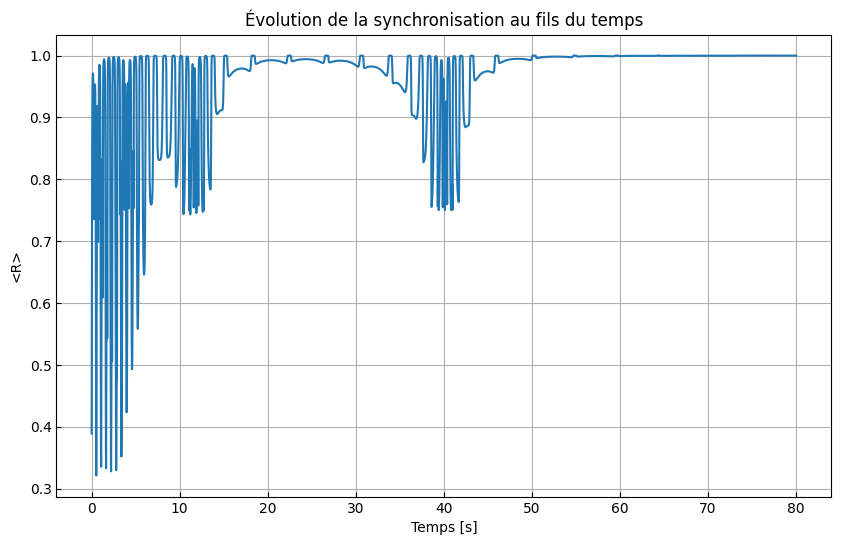

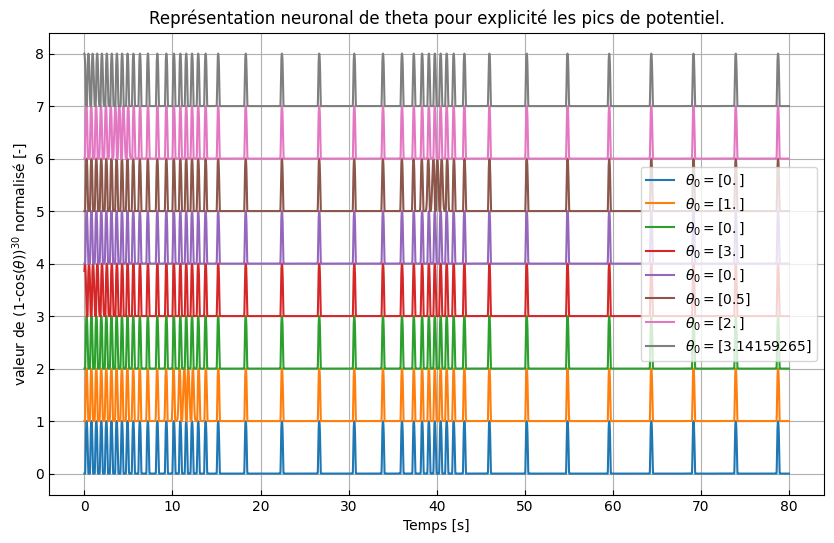

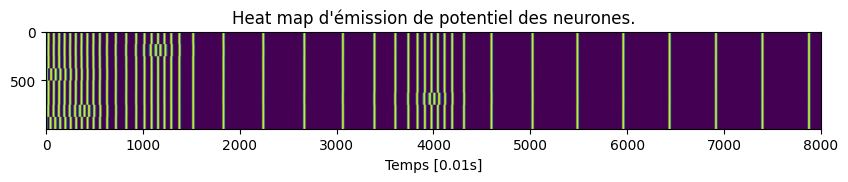

In [ ]:
# old Dynamique N neurone theta.
theta_0 = np.array([[0], [1], [0], [3], [0], [0.5], [2], [np.pi]])
A = np.ones((len(theta_0), len(theta_0)))
time_start = 0
time_step = 0.01
time_stop = 80
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, betaNneurones, A, 2, 0.1, 20)

# plt.figure(figsize=(10, 6))
# for i in range(len(theta_0)):
#     plt.plot(time_list, 2*i+beta[i], label = fr'$\theta_0={theta_0[i]}$')
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"valeur de $\beta$ [-]")
# plt.title(r"Évolution de $\beta$ au fils du temps")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.legend()
# plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, indice_syncronisation(theta))
plt.xlabel(r"Temps [s]")
plt.ylabel(r"<R>")
plt.title(r"Évolution de la synchronisation au fils du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for i in range(len(theta_0)):
    plt.plot(time_list, i+spike_rep(theta[i], 30)/2**30, label = fr'$\theta_0={theta_0[i]}$')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^{30}$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
output = spike_rep(theta, 30)/2**30
plt.imshow(np.repeat(output, int(time_stop/(len(theta_0)*8*time_step)), axis=0))
plt.xlabel(fr"Temps [{time_step}s]")
# plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Heat map d'émission de potentiel des neurones.")
plt.show()

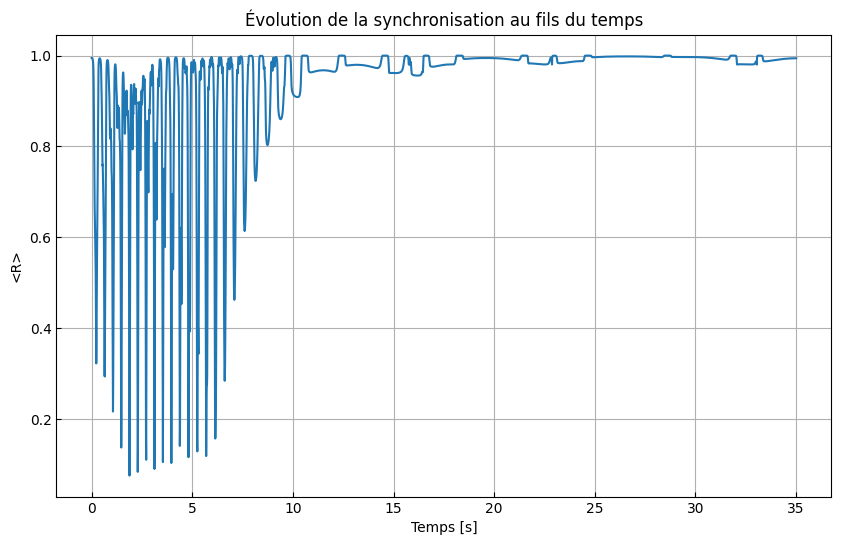

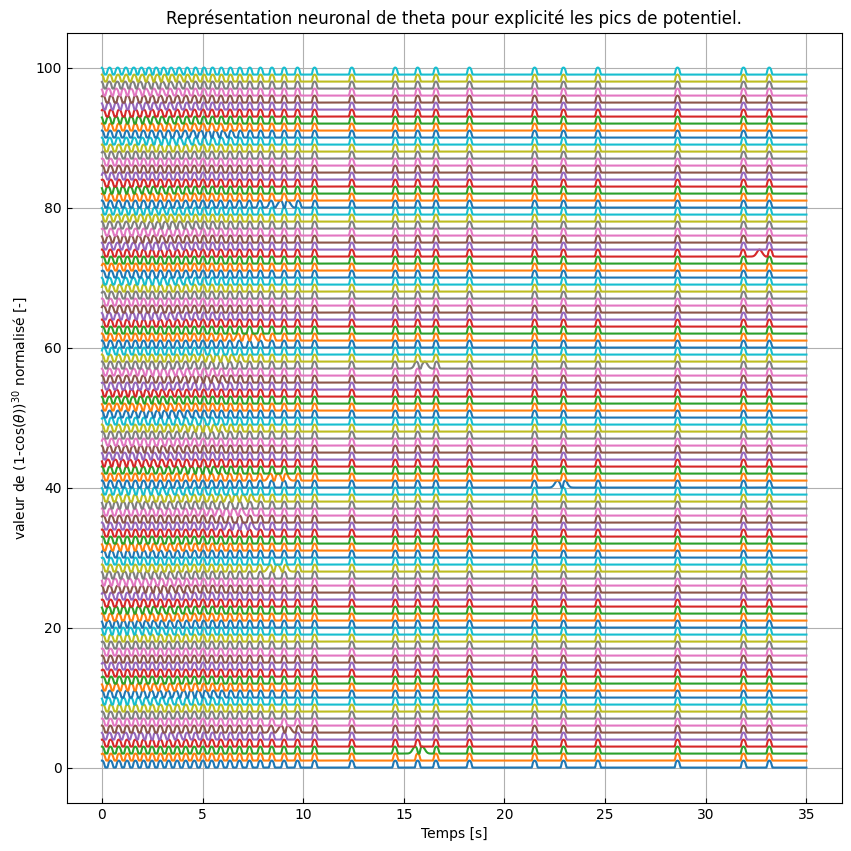

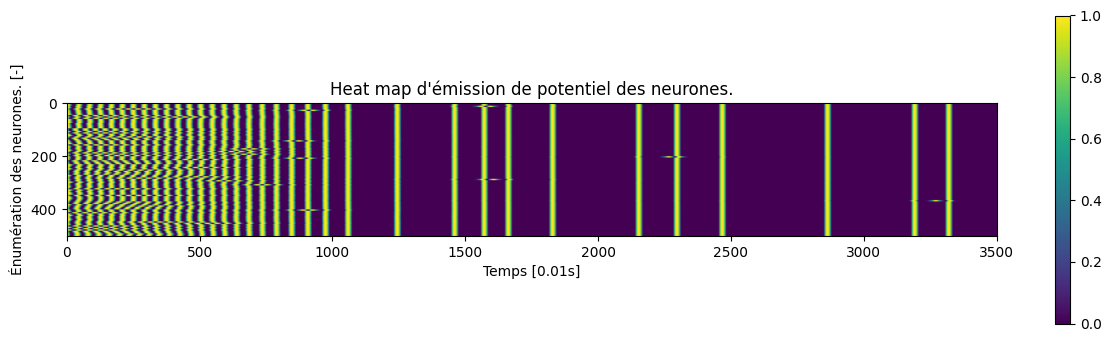

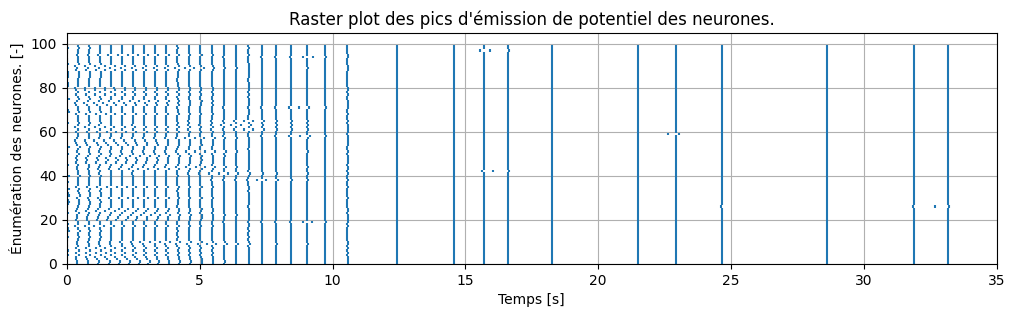

In [100]:
# Dynamique N neurone theta.
size = 100
theta_0 = np.random.normal(np.pi, 0.1, (size, 1))
A = np.ones((size, size))
# A = np.random.normal(0.5, 0.3, (size, size))
time_start = 0
time_step = 0.01
time_stop = 35
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique_N_neurones(time_step, time_stop, theta_0, theta_model, betaNneurones, A, 2, 0.1, 30)

# plt.figure(figsize=(10, 6))
# for i in range(len(theta_0)):
#     plt.plot(time_list, 2*i+beta[i], label = fr'$\theta_0={theta_0[i]}$')
# plt.xlabel(r"Temps [s]")
# plt.ylabel(r"valeur de $\beta$ [-]")
# plt.title(r"Évolution de $\beta$ au fils du temps")
# plt.tick_params(direction = 'in')
# plt.grid(True)
# plt.legend()
# plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, indice_syncronisation(theta))
plt.xlabel(r"Temps [s]")
plt.ylabel(r"<R>")
plt.title(r"Évolution de la synchronisation au fils du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()


raster_plot_array = []

plt.figure(figsize=(10, 10))
for i in range(len(theta_0)):
    spike_rep_list = spike_rep(theta[i], 30)/2**30
    plt.plot(time_list, i+spike_rep_list, label = fr'$\theta_0={theta_0[i]}$')
    raster_plot_array += [time_list[find_peaks(spike_rep_list, 0.5)[0]]]
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^{30}$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
# plt.legend()
plt.show()

plt.figure(figsize=(15, 4))
output = spike_rep(theta, 30)/2**30
V_spike_mat = np.repeat(output, 1+int(time_stop/(len(theta_0)*8*time_step)), axis=0)
plt.imshow(V_spike_mat)
plt.colorbar()
plt.xlabel(fr"Temps [{time_step}s]")
plt.ylabel(r"Énumération des neurones. [-]")
plt.title(r"Heat map d'émission de potentiel des neurones.")
plt.show()

plt.figure(figsize=(12, 3))
plt.eventplot(raster_plot_array[::-1])
plt.xlabel(fr"Temps [s]")
plt.ylabel(r"Énumération des neurones. [-]")
plt.title(r"Raster plot des pics d'émission de potentiel des neurones.")
plt.grid(True)
# plt.margins(0)
plt.xlim(0, time_stop)
plt.ylim(0)
plt.show()

Networkx
- gnm
- Erdos-Renyi ++
- Configuration model

poid sompolinski

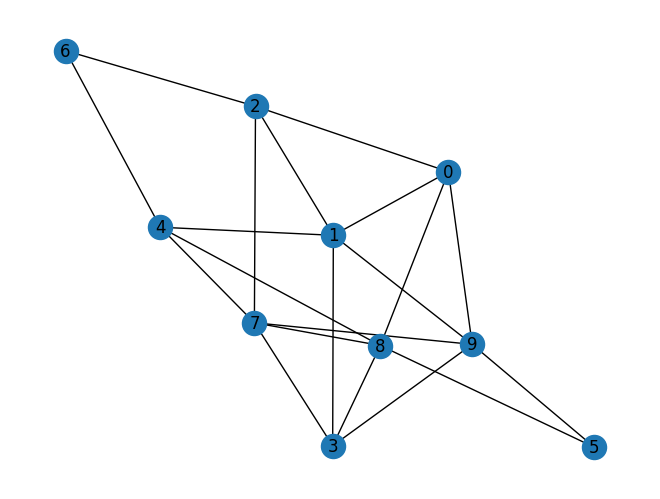

In [ ]:
# Erdos-Renyi exemple by Networkx
n = 10  # 10 nodes
m = 20  # 20 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)

pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos, with_labels=True)
plt.show()

MultiGraph with 8 nodes and 16 edges 16
[4 7 3 6 2 3 5 2]
[(0, 3, 0), (0, 0, 0), (0, 4, 0), (1, 3, 0), (1, 3, 1), (1, 5, 0), (1, 6, 0), (1, 6, 1), (1, 6, 2), (1, 7, 0), (2, 3, 0), (2, 4, 0), (2, 6, 0), (3, 7, 0), (3, 5, 0), (5, 6, 0)]


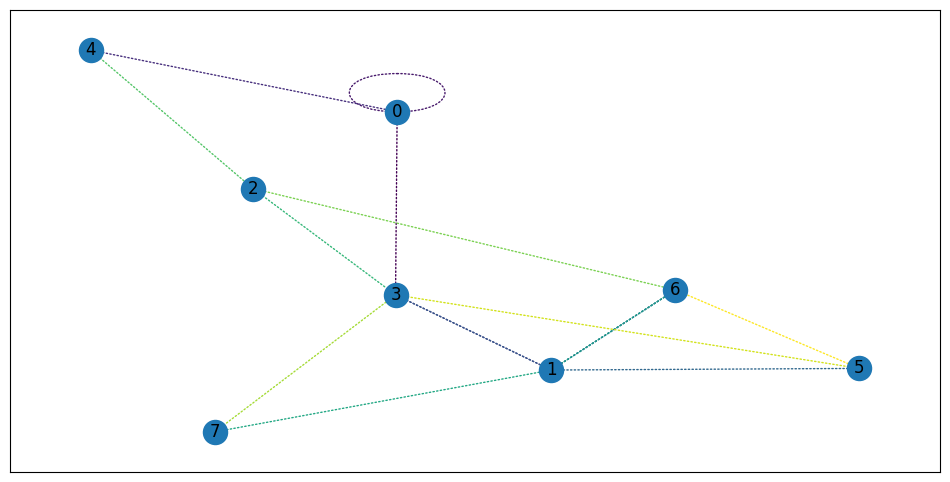

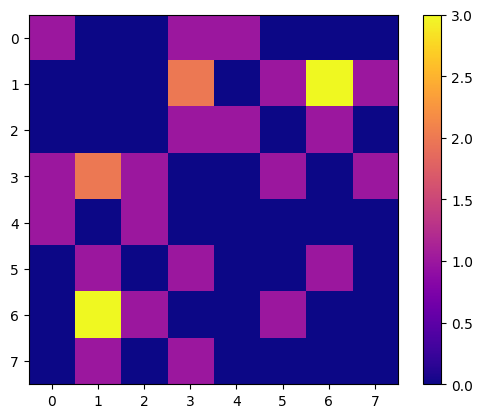

In [ ]:
# Configuration model exemple and try about multigraph plot (unsuccesful)
degree_list = [4, 7, 3, 6, 2, 3, 5, 2]
G = nx.configuration_model(degree_list)
graph_degree = int(sum(degree_list)/2)
print(G, graph_degree)

A = np.array(nx.adjacency_matrix(G).toarray())
print(np.sum(A+np.diag(np.diag(A)), axis=1))
print(list(G.edges))

plt.figure(figsize=(12, 6))
nx.draw_networkx(G, style=':', edge_color=tuple(np.linspace(0, 1, graph_degree)),  with_labels=True)
plt.show()

plt.imshow(A, cmap='plasma')
plt.colorbar()
plt.show()

[[0 1 1 1 1]
 [1 0 1 1 1]
 [1 1 0 1 1]
 [1 1 1 0 1]
 [1 1 1 1 0]]
\documentclass{report}
\usepackage{tikz}
\usepackage{subcaption}

\begin{document}
\begin{figure}
  \begin{tikzpicture}
      \draw
        (0.0:2) node (0){0}
        (72.0:2) node (1){1}
        (144.0:2) node (2){2}
        (216.0:2) node (3){3}
        (288.0:2) node (4){4};
      \begin{scope}[-]
        \draw (0) to (1);
        \draw (0) to (2);
        \draw (0) to (3);
        \draw (0) to (4);
        \draw (1) to (2);
        \draw (1) to (3);
        \draw (1) to (4);
        \draw (2) to (3);
        \draw (2) to (4);
        \draw (3) to (4);
      \end{scope}
    \end{tikzpicture}
  \caption{Pentagrame}
\end{figure}
\end{document}


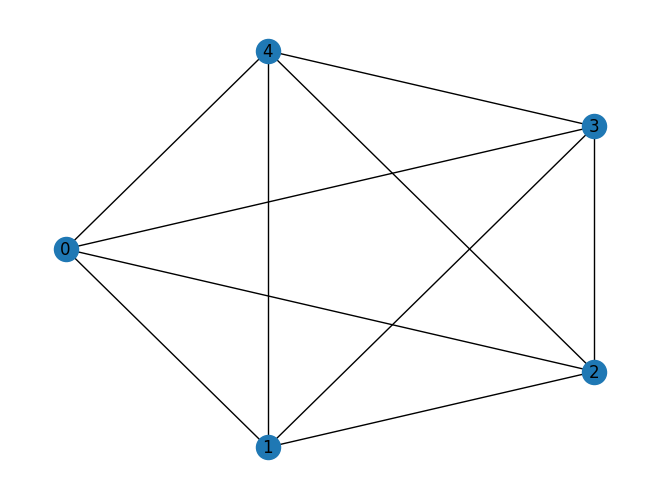

In [133]:
# Latex code for k_5 graph
G1 = nx.dense_gnm_random_graph(5, 10)
G = nx.complete_graph(5)
A = nx.adjacency_matrix(G)
print(np.array(A.toarray()))
nx.draw_shell(G, with_labels=True)
print(nx.to_latex(G, caption="Pentagrame"))